In [1]:
#Import
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load training
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


/home/jtlumpk/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#neural net
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(NeuralNet, self).__init__()
        self.flattener = nn.Flatten()
        layers = [nn.Linear(input_size, hidden_layers[0])]
        layers += [nn.Linear(hidden_layers[i], hidden_layers[i + 1]) for i in range(len(hidden_layers) - 1)]
        layers.append(nn.Linear(hidden_layers[-1], output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = self.flattener(x)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
def train_and_evaluate(model, trainloader, testloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #Store info
    epoch_train_loss = []
    epoch_train_accuracy = []
    epoch_test_loss = []
    epoch_test_accuracy = []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total_items = 0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_items += labels.size(0)

        epoch_train_loss.append(total_loss / len(trainloader))
        epoch_train_accuracy.append(total_correct / total_items)

        # Evaluation
        model.eval()
        total_loss, total_correct, total_items = 0, 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_items += labels.size(0)

        epoch_test_loss.append(total_loss / len(testloader))
        epoch_test_accuracy.append(total_correct / total_items)

    # Return the metrics of the last epoch
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {epoch_train_loss[-1]:.4f}, Train Accuracy: {epoch_train_accuracy[-1]:.4f}, Test Loss: {epoch_test_loss[-1]:.4f}, Test Accuracy: {epoch_test_accuracy[-1]:.4f}")
    return epoch_train_loss[-1], epoch_train_accuracy[-1], epoch_test_loss[-1], epoch_test_accuracy[-1]

In [5]:
model_configurations = [
    ([784], 10),
    ([784, 128], 10),
    ([784, 128, 64], 10),
    ([784, 256], 10),
    ([784, 256, 128], 10),
    ([784, 512], 10),
    ([784, 512, 256], 10),
    ([784, 512, 256, 128], 10),
    ([784, 1024], 10),
    ([784, 1024, 512], 10),
]

data_for_plotting = {
    "parameters": [],
    "train_loss": [],
    "test_loss": [],
    "train_accuracy": [],
    "test_accuracy": []
}

for config in model_configurations:
    input_size, hidden_sizes, output_size = 784, config[0], 10
    model = NeuralNet(input_size, hidden_sizes, output_size)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Training model with {num_params} parameters: Input -> {hidden_sizes} -> Output")
    train_loss, train_accuracy, test_loss, test_accuracy = train_and_evaluate(model, trainloader, testloader, epochs=10)
    
    data_for_plotting["parameters"].append(num_params)
    data_for_plotting["train_loss"].append(train_loss)
    data_for_plotting["test_loss"].append(test_loss)
    data_for_plotting["train_accuracy"].append(train_accuracy)
    data_for_plotting["test_accuracy"].append(test_accuracy)


Training model with 623290 parameters: Input -> [784] -> Output
Epoch 1/10 - Train Loss: 0.3435, Train Accuracy: 0.8985, Test Loss: 0.1874, Test Accuracy: 0.9432
Epoch 2/10 - Train Loss: 0.1576, Train Accuracy: 0.9538, Test Loss: 0.1221, Test Accuracy: 0.9638
Epoch 3/10 - Train Loss: 0.1114, Train Accuracy: 0.9674, Test Loss: 0.0935, Test Accuracy: 0.9722
Epoch 4/10 - Train Loss: 0.0879, Train Accuracy: 0.9739, Test Loss: 0.0934, Test Accuracy: 0.9709
Epoch 5/10 - Train Loss: 0.0717, Train Accuracy: 0.9786, Test Loss: 0.0813, Test Accuracy: 0.9751
Epoch 6/10 - Train Loss: 0.0611, Train Accuracy: 0.9818, Test Loss: 0.0778, Test Accuracy: 0.9767
Epoch 7/10 - Train Loss: 0.0521, Train Accuracy: 0.9847, Test Loss: 0.0677, Test Accuracy: 0.9786
Epoch 8/10 - Train Loss: 0.0443, Train Accuracy: 0.9868, Test Loss: 0.0650, Test Accuracy: 0.9788
Epoch 9/10 - Train Loss: 0.0401, Train Accuracy: 0.9879, Test Loss: 0.0615, Test Accuracy: 0.9803
Epoch 10/10 - Train Loss: 0.0340, Train Accuracy: 0.99

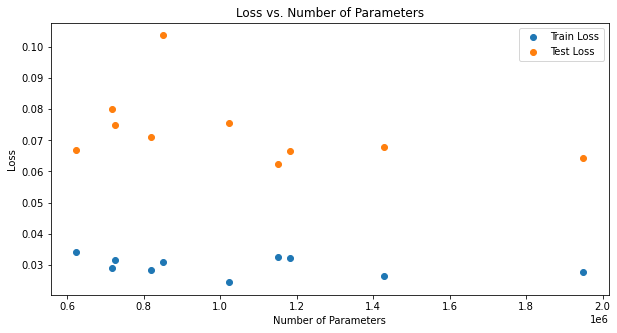

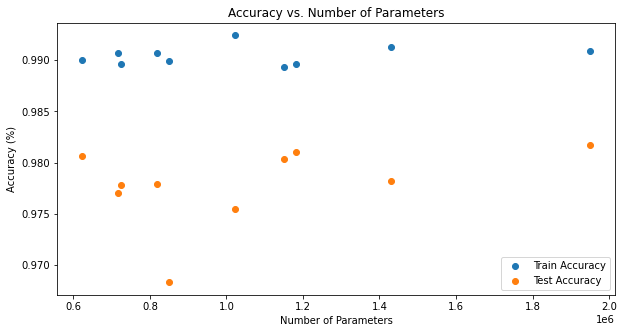

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(data_for_plotting["parameters"], data_for_plotting["train_loss"], label='Train Loss')
plt.scatter(data_for_plotting["parameters"], data_for_plotting["test_loss"], label='Test Loss')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Parameters')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.scatter(data_for_plotting["parameters"], data_for_plotting["train_accuracy"], label='Train Accuracy')
plt.scatter(data_for_plotting["parameters"], data_for_plotting["test_accuracy"], label='Test Accuracy'd)
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Number of Parameters')
plt.legend()
plt.show()